# 2. Neural Networks

## 2.4 Convolutional Neural Networks Implemenatation

In this notebook, we will implement LeNet-5, AlexNet and VGG-16 archtectures and test them on the Tiny Imagenet Dataset using the Adam Optimizer. We further investigate the relative merits of the Adam, SGD and SGD with momentum optimizers on the MNIST dataset on LeNet-5

### Import Statements

In [ ]:
!unzip /content/drive/MyDrive/tiny-imagenet-200.zip

In [ ]:
#print (torch.__version__)

In [ ]:
import numpy as np
import os
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print (DEVICE)

### Global Variables

In [2]:
# Global Variables
BATCH_SIZE = 64
LEARNING_RATE = 0.001
N_EPOCHS = 60
RANDOM_SEED = 32

N_CLASSES = 200

### Run Models

In [3]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='green', label='Training loss') 
    ax.plot(valid_losses, color='orange', label='Testing loss')
    ax.set(title="Loss across epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('ggplot')

def train_optm (train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop_optm (model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_optm (train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)}     '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.3f}\t'
                  f'Test loss: {valid_loss:.3f}\t'
                  f'Train accuracy: {100 * train_acc:.3f}\t'
                  f'Test accuracy: {100 * valid_acc:.3f}')
            
    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)



## LeNet-5


### Transform data for LeNet-5

In [ ]:
# Path to train, test and val data
here = os.path.dirname(os.path.realpath('__file__'))
subdir = "tiny-imagenet-200"
test_dir = os.path.join(here, subdir, "test")
train_dir = os.path.join(here, subdir, "train")
val_dir = os.path.join(here, subdir, "val")

# Transform images into 32 pixels x 32 pixels as reqd by LeNet-5
mean = (0.48093379, 0.44808328, 0.39650237)
stddev = (0.22996924, 0.22610814, 0.22566715)
my_trans = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor(), transforms.Normalize(mean, stddev)])

# Make dataset objects
#test_data = datasets.ImageFolder (test_dir, transform = my_trans)
tot_data = datasets.ImageFolder (train_dir, transform = my_trans)
#print (len(tot_data[0][0][0][0]))
train_data, val_data = random_split (tot_data, [90000, 10000])
#print (len(val_data[0][0]))
#val_data = datasets.ImageFolder (val_dir, transform = my_trans)
#test_load = DataLoader (dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)
train_load = DataLoader (dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_load = DataLoader (dataset=val_data, batch_size=BATCH_SIZE, shuffle=True)

### LeNet-5 Class

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

### Intialize LeNet-5

In [ ]:

torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

### LeNet-5 with optimizer

Run 120 epochs on AlexNet with Adam Optimizer on Tiny ImageNet with a batch size of 32 and constant learning rate of 0.001.

06:22:01     Epoch: 9	Train loss: 3.980	Test loss: 4.231	Train accuracy: 16.461	Test accuracy: 11.960
06:31:22     Epoch: 19	Train loss: 3.740	Test loss: 4.292	Train accuracy: 19.969	Test accuracy: 11.780
06:40:38     Epoch: 29	Train loss: 3.595	Test loss: 4.407	Train accuracy: 21.654	Test accuracy: 11.850
06:49:53     Epoch: 39	Train loss: 3.493	Test loss: 4.490	Train accuracy: 23.994	Test accuracy: 11.650
06:59:09     Epoch: 49	Train loss: 3.417	Test loss: 4.574	Train accuracy: 25.329	Test accuracy: 10.770
07:08:23     Epoch: 59	Train loss: 3.350	Test loss: 4.656	Train accuracy: 26.612	Test accuracy: 10.540
07:17:38     Epoch: 69	Train loss: 3.301	Test loss: 4.748	Train accuracy: 26.933	Test accuracy: 10.080
07:26:54     Epoch: 79	Train loss: 3.253	Test loss: 4.820	Train accuracy: 27.226	Test accuracy: 9.750
07:36:14     Epoch: 89	Train loss: 3.218	Test loss: 4.892	Train accuracy: 27.147	Test accuracy: 9.440
07:45:37     Epoch: 99	Train loss: 3.183	Test loss: 4.935	Train accuracy: 28

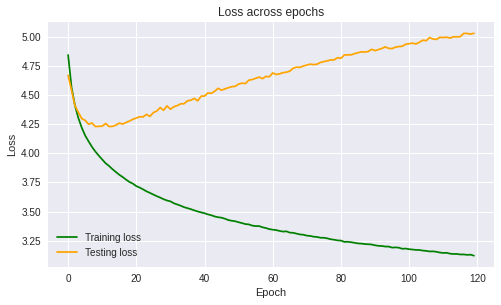

In [ ]:
model, optimizer, _ = training_loop_optm (model, criterion, optimizer, train_load, val_load, N_EPOCHS, DEVICE, print_every = 10)

## AlexNet

### Transform data (AlexNet and VGG-16)

In [ ]:
# Preprocess images

# Path to train, test and val data
here = os.path.dirname(os.path.realpath('__file__'))
subdir = "tiny-imagenet-200"
test_dir = os.path.join(here, subdir, "test")
train_dir = os.path.join(here, subdir, "train")
val_dir = os.path.join(here, subdir, "val")

mean = (0.48093379, 0.44808328, 0.39650237)
stddev = (0.22996924, 0.22610814, 0.22566715)

my_trans = transforms.Compose([
  #transforms.Resize(256),
  #transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean, stddev),
])

# Make dataset objects
#test_data = datasets.ImageFolder (test_dir, transform = my_trans)
#val_data = datasets.ImageFolder (val_dir, transform = my_trans)
tot_data = datasets.ImageFolder (train_dir, transform = my_trans)
train_data, val_data = random_split (tot_data, [90000, 10000])
#test_load = DataLoader (dataset=test_data, batch_size=BATCH_SIZE, 
#                         shuffle=True)
#print (len(tot_data[0][0][0]))
train_load = DataLoader (dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_load = DataLoader (dataset=val_data, batch_size=BATCH_SIZE, 
                          shuffle=True)

### AlexNet Class

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        #self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        #x = self.avgpool(x)
        out = torch.flatten(x, 1)
        logit = self.classifier(out)
        probs = F.softmax(logit, dim=1)
        return logit, probs

### Initialize AlexNet

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet (N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

### AlexNet with Adam optimizer

Run 120 epochs on AlexNet with Adam Optimizer on Tiny ImageNet with a batch size of 64 and learning rate of 0.001

13:07:55     Epoch: 0	Train loss: 5.097	Test loss: 4.976	Train accuracy: 2.180	Test accuracy: 2.210
13:09:36     Epoch: 1	Train loss: 4.914	Test loss: 4.868	Train accuracy: 3.142	Test accuracy: 3.510
13:11:17     Epoch: 2	Train loss: 4.761	Test loss: 4.675	Train accuracy: 4.987	Test accuracy: 4.610
13:12:58     Epoch: 3	Train loss: 4.639	Test loss: 4.570	Train accuracy: 6.313	Test accuracy: 5.990
13:14:38     Epoch: 4	Train loss: 4.560	Test loss: 4.499	Train accuracy: 6.961	Test accuracy: 6.660
13:16:19     Epoch: 5	Train loss: 4.496	Test loss: 4.502	Train accuracy: 7.306	Test accuracy: 6.820
13:18:00     Epoch: 6	Train loss: 4.446	Test loss: 4.422	Train accuracy: 7.922	Test accuracy: 7.290
13:19:41     Epoch: 7	Train loss: 4.408	Test loss: 4.383	Train accuracy: 8.761	Test accuracy: 8.600
13:21:22     Epoch: 8	Train loss: 4.361	Test loss: 4.355	Train accuracy: 9.093	Test accuracy: 8.510
13:23:03     Epoch: 9	Train loss: 4.328	Test loss: 4.287	Train accuracy: 10.258	Test accuracy: 9.250

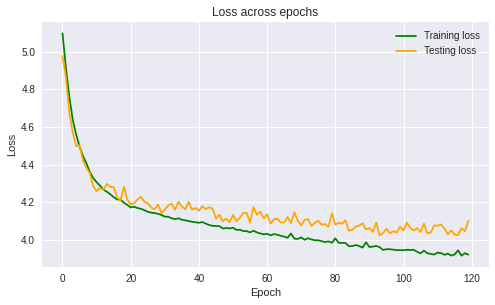

In [ ]:
model, optimizer, _ = training_loop_optm (model, criterion, optimizer, train_load, val_load, N_EPOCHS, DEVICE, print_every = 1)

#VGG-16

## VGG-16 class

In [ ]:
def conv_layer(chann_in, chann_out, k_size, p_size):
    layer = nn.Sequential(
        nn.Conv2d(chann_in, chann_out, kernel_size=k_size, padding=p_size),
        nn.BatchNorm2d(chann_out),
        nn.ReLU()
    )
    return layer

def vgg_conv_block(in_list, out_list, k_list, p_list, pooling_k, pooling_s):

    layers = [ conv_layer(in_list[i], out_list[i], k_list[i], p_list[i]) for i in range(len(in_list)) ]
    layers += [ nn.MaxPool2d(kernel_size = pooling_k, stride = pooling_s)]
    return nn.Sequential(*layers)

def vgg_fc_layer(size_in, size_out):
    layer = nn.Sequential(
        nn.Linear(size_in, size_out),
        nn.BatchNorm1d(size_out),
        nn.ReLU()
    )
    return layer

class VGG16(nn.Module):
    def __init__(self, n_classes=1000):
        super(VGG16, self).__init__()

        # Conv blocks (BatchNorm + ReLU activation added in each block)
        self.layer1 = vgg_conv_block([3,64], [64,64], [3,3], [1,1], 2, 2)
        self.layer2 = vgg_conv_block([64,128], [128,128], [3,3], [1,1], 2, 2)
        self.layer3 = vgg_conv_block([128,256,256], [256,256,256], [3,3,3], [1,1,1], 2, 2)
        self.layer4 = vgg_conv_block([256,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)
        self.layer5 = vgg_conv_block([512,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)

        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # FC layers
        self.layer6 = vgg_fc_layer(512*7*7, 4096)
        self.layer7 = vgg_fc_layer(4096, 4096)

        # Final layer
        self.layer8 = nn.Linear(4096, n_classes)

        self.layer82 = nn.Linear(512, n_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        #out = self.avgpool(out)
        #out = torch.flatten(out, 1)
        vgg16_features = self.layer5(out)
        out = vgg16_features.view(out.size(0), -1)
        #out = self.layer6(out)
        #out = self.layer7(out)
        #out = self.layer8(out)
        out = self.layer82(out)
        probs = F.softmax(out, dim=1)
        return out, probs


### VGG-16 initialization

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = VGG16(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

### VGG-16 with optimizer

Run 60 epochs on VGG-16 with Adam Optimizer with a batch size of 64 and a learning rate of 0.001 on Tiny ImageNet Dataset.

19:38:23     Epoch: 9	Train loss: 2.765	Test loss: 4.149	Train accuracy: 11.961	Test accuracy: 10.120
20:05:22     Epoch: 19	Train loss: 1.142	Test loss: 3.799	Train accuracy: 42.714	Test accuracy: 23.340
20:32:27     Epoch: 29	Train loss: 0.342	Test loss: 5.112	Train accuracy: 75.284	Test accuracy: 28.150
20:59:32     Epoch: 39	Train loss: 0.195	Test loss: 5.877	Train accuracy: 78.541	Test accuracy: 28.000
21:26:38     Epoch: 49	Train loss: 0.139	Test loss: 6.021	Train accuracy: 85.754	Test accuracy: 29.290
21:53:42     Epoch: 59	Train loss: 0.109	Test loss: 6.399	Train accuracy: 87.486	Test accuracy: 29.590


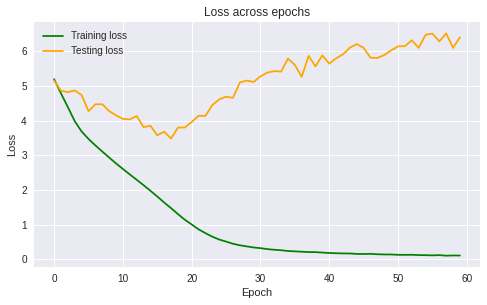

In [ ]:
model, optimizer, _ = training_loop_optm (model, criterion, optimizer, train_load, val_load, N_EPOCHS, DEVICE, print_every = 10)

## 2.5 Comparing Optimizers on LeNet-5

Here we compare SGD, SGD with momentum and Adam on MNIST Dataset using LeNet-5 for 60 epochs with a learning rate of 0.001 and a batch size of 64.

### Importing Data

In [ ]:
# Path to train, test and val data
here = os.path.dirname(os.path.realpath('__file__'))
subdir = "mnist"
test_dir = os.path.join(here, subdir, "test")
train_dir = os.path.join(here, subdir, "train")
val_dir = os.path.join(here, subdir, "val")

# Transform images into 32 pixels x 32 pixels as reqd by LeNet-5
mean = (0.44808328)
stddev = (0.22610814)
my_trans_mnist = transforms.Compose([
                               transforms.Resize((32, 32)),
                                 transforms.ToTensor(), 
                               transforms.Normalize(mean, stddev)])

# Make dataset objects
train_data_mnist = datasets.MNIST (train_dir, train = True, transform = my_trans_mnist, download = True)
test_data_mnist = datasets.MNIST (test_dir, train = False, transform = my_trans_mnist, download = True)
train_load_mnist = DataLoader (dataset=train_data_mnist, batch_size=BATCH_SIZE, shuffle=True)
test_load_mnist = DataLoader (dataset=test_data_mnist, batch_size=BATCH_SIZE, shuffle=True)

#print (len(train_data[0][0]))

### LeNet-5

We slightly modify LeNet-5 from what was used earlier because now we are working with only one input channel.

In [9]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

### LeNet-5 with SGD optimizer


19:01:47     Epoch: 9	Train loss: 1.231	Test loss: 1.120	Train accuracy: 75.808	Test accuracy: 76.560
19:05:53     Epoch: 19	Train loss: 0.447	Test loss: 0.416	Train accuracy: 88.848	Test accuracy: 89.220
19:10:01     Epoch: 29	Train loss: 0.307	Test loss: 0.285	Train accuracy: 91.747	Test accuracy: 92.220
19:14:08     Epoch: 39	Train loss: 0.240	Test loss: 0.223	Train accuracy: 93.320	Test accuracy: 93.760
19:18:12     Epoch: 49	Train loss: 0.196	Test loss: 0.182	Train accuracy: 94.492	Test accuracy: 94.920
19:22:15     Epoch: 59	Train loss: 0.164	Test loss: 0.152	Train accuracy: 95.398	Test accuracy: 95.770


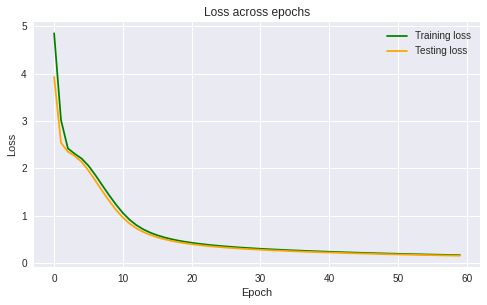

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop_optm (model, criterion, optimizer, train_load_mnist, test_load_mnist, N_EPOCHS, DEVICE, print_every = 10)

### LeNet-5 with SGD with Momentum optimizer

19:47:43     Epoch: 9	Train loss: 0.460	Test loss: 0.415	Train accuracy: 88.875	Test accuracy: 89.250
19:51:53     Epoch: 19	Train loss: 0.243	Test loss: 0.224	Train accuracy: 93.322	Test accuracy: 93.670
19:56:07     Epoch: 29	Train loss: 0.165	Test loss: 0.152	Train accuracy: 95.385	Test accuracy: 95.810
20:00:19     Epoch: 39	Train loss: 0.124	Test loss: 0.114	Train accuracy: 96.527	Test accuracy: 96.810
20:04:32     Epoch: 49	Train loss: 0.099	Test loss: 0.091	Train accuracy: 97.210	Test accuracy: 97.400
20:08:44     Epoch: 59	Train loss: 0.083	Test loss: 0.077	Train accuracy: 97.657	Test accuracy: 97.730


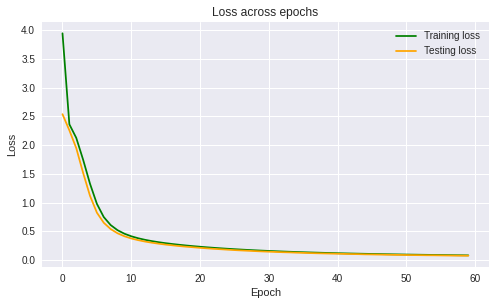

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop_optm (model, criterion, optimizer, train_load_mnist, test_load_mnist, N_EPOCHS, DEVICE, print_every = 10)

### LeNet-5 with Adam optimizer

18:35:52     Epoch: 9	Train loss: 0.017	Test loss: 0.048	Train accuracy: 99.557	Test accuracy: 98.670
18:40:14     Epoch: 19	Train loss: 0.008	Test loss: 0.056	Train accuracy: 99.760	Test accuracy: 98.640
18:44:35     Epoch: 29	Train loss: 0.005	Test loss: 0.053	Train accuracy: 99.903	Test accuracy: 98.790
18:48:57     Epoch: 39	Train loss: 0.005	Test loss: 0.062	Train accuracy: 99.813	Test accuracy: 98.670
18:53:18     Epoch: 49	Train loss: 0.002	Test loss: 0.061	Train accuracy: 99.925	Test accuracy: 98.720
18:57:36     Epoch: 59	Train loss: 0.004	Test loss: 0.063	Train accuracy: 99.817	Test accuracy: 98.640


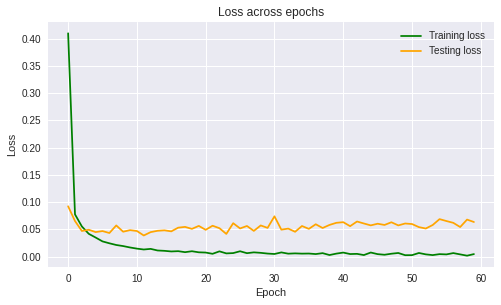

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop_optm (model, criterion, optimizer, train_load_mnist, test_load_mnist, N_EPOCHS, DEVICE, print_every = 10)

# 3. Learning++

## 3.3 Cross Training 

Here we will perform cross training by first training on SVHN dataset and testing on MNIST and vice versa

### Importing SVHN Data

In [7]:
# Path to train, test and val data
here = os.path.dirname(os.path.realpath('__file__'))
subdir = "svhn"
test_dir = os.path.join(here, subdir, "test")
train_dir = os.path.join(here, subdir, "train")
val_dir = os.path.join(here, subdir, "val")

# Transform images into 32 pixels x 32 pixels as reqd by LeNet-5
mean = (0.44808328)
stddev = (0.22610814)
my_trans_svhn = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((32, 32)),
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean, stddev)])

# Make dataset objects
train_data_svhn = datasets.SVHN (train_dir, split = 'train', transform = my_trans_svhn, download = True)
test_data_svhn = datasets.SVHN (test_dir, split = 'test', transform = my_trans_svhn, download = True)
train_load_svhn = DataLoader (dataset=train_data_svhn, batch_size=BATCH_SIZE, shuffle=True)
test_load_svhn = DataLoader (dataset=test_data_svhn, batch_size=BATCH_SIZE, shuffle=True)

print (len(train_data_svhn[0][0]))

Using downloaded and verified file: /content/svhn/train/train_32x32.mat
Using downloaded and verified file: /content/svhn/test/test_32x32.mat
1


### Training on SVHN and testing on MNIST

12:44:50     Epoch: 9	Train loss: 2.244	Test loss: 2.366	Train accuracy: 18.921	Test accuracy: 11.350
12:48:41     Epoch: 19	Train loss: 2.244	Test loss: 2.359	Train accuracy: 18.921	Test accuracy: 11.350
12:52:32     Epoch: 29	Train loss: 1.868	Test loss: 2.023	Train accuracy: 39.181	Test accuracy: 22.040
12:56:20     Epoch: 39	Train loss: 0.457	Test loss: 1.396	Train accuracy: 86.202	Test accuracy: 57.150
13:00:08     Epoch: 49	Train loss: 0.365	Test loss: 1.279	Train accuracy: 89.619	Test accuracy: 62.000
13:03:57     Epoch: 59	Train loss: 0.311	Test loss: 1.638	Train accuracy: 91.038	Test accuracy: 57.830


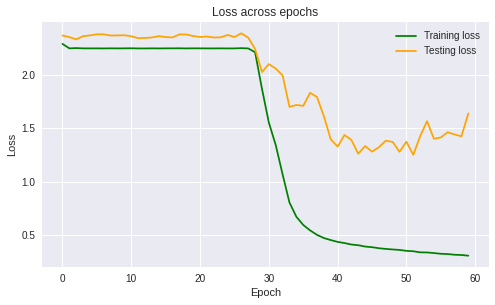

In [10]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop_optm (model, criterion, optimizer, train_load_svhn, test_load_mnist, N_EPOCHS, DEVICE, print_every = 10)

### Training on MNIST and testing on SVHN

13:07:33     Epoch: 9	Train loss: 0.017	Test loss: 7.881	Train accuracy: 99.585	Test accuracy: 22.538
13:11:09     Epoch: 19	Train loss: 0.008	Test loss: 10.092	Train accuracy: 99.657	Test accuracy: 21.593
13:14:44     Epoch: 29	Train loss: 0.007	Test loss: 11.173	Train accuracy: 99.847	Test accuracy: 21.988
13:18:20     Epoch: 39	Train loss: 0.005	Test loss: 11.526	Train accuracy: 99.928	Test accuracy: 23.268
13:21:54     Epoch: 49	Train loss: 0.005	Test loss: 11.845	Train accuracy: 99.898	Test accuracy: 22.215
13:25:29     Epoch: 59	Train loss: 0.003	Test loss: 12.582	Train accuracy: 99.868	Test accuracy: 22.695


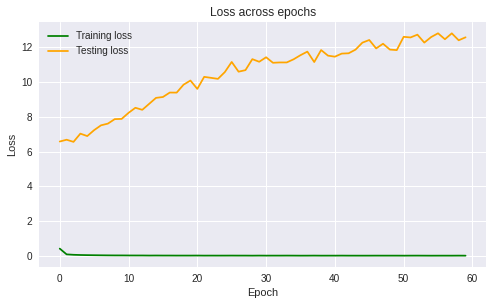

In [11]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop_optm (model, criterion, optimizer, train_load_mnist, test_load_svhn, N_EPOCHS, DEVICE, print_every = 10)